<a href="https://colab.research.google.com/github/SarahJobyDavid/Potato-Disease-Classification/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [10]:
IMAGE_SIZE = 256 # taken from the images used
BATCH_SIZE = 32 # 32 images per batch
EPOCH = 20

In [11]:
import os
print(os.listdir())  # Lists everything in the current directory

['.config', 'PlantVillage.zip', 'sample_data']


In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
!unzip PlantVillage.zip

Archive:  PlantVillage.zip
   creating: PlantVillage/
   creating: PlantVillage/Potato___Early_blight/
  inflating: PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: PlantVillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: PlantVillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: PlantVillage/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: PlantVillage/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: PlantVillage/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: PlantVillage/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG  
  inflating: PlantVillage

In [14]:
import os
print(os.listdir())  # should list 'PlantVillage'

['.config', 'PlantVillage', 'PlantVillage.zip', 'sample_data']


In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True, # this will randomly shuffle the images and load them
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 2152 files belonging to 3 classes.


In [16]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [17]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 2 2 0 1 1 0 0 1]


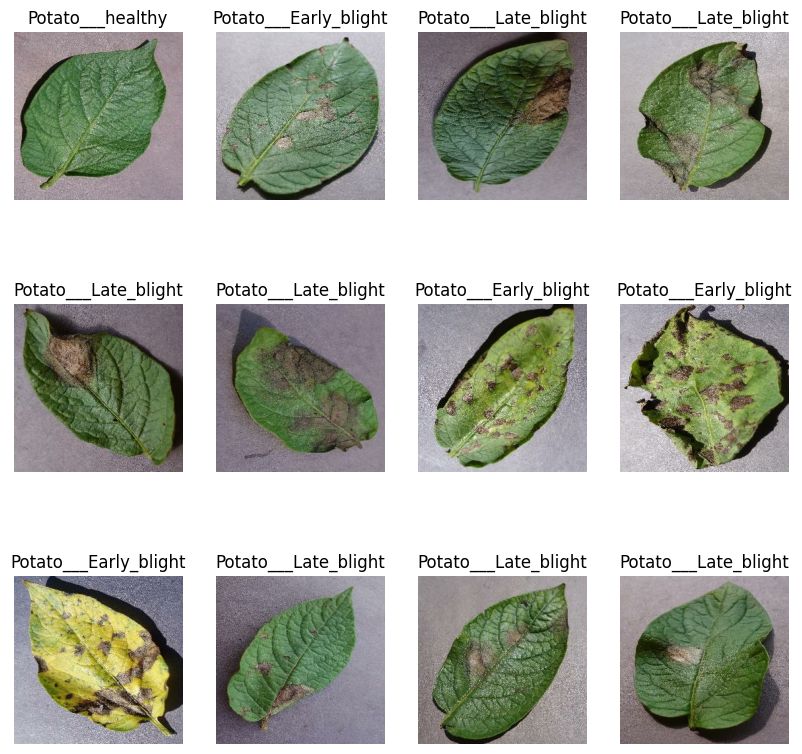

In [18]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [20]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) <= 1

    ds_size = tf.data.experimental.cardinality(ds).numpy()

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)   #prefetch: if cpu is busy prefetch will load the next set of batch from the disk
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

this helps to optimize the datasets that helps in faster training

In [23]:
#PREPROCESSING
resize_and_rescale= tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [24]:
#AUGMENTATION
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_verical"),
    layers.RandomRotation(0.2)
])

In [25]:
#CONVOLUTION NEURAL NETWORK
n_classes =3
CHANNELS = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    #set of layers
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation= 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3),activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3),activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3),activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3),activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3),activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')# THIS IS THE LAST LAYER THAT WILL HAVE 3 NEURONS
    # SOFTMAX ACTVATION FUNCTION NORMALIZES THE PROBABILITY OF THE CLASSES
])

model.build(input_shape = input_shape) #just an api , api requires this
# With this the model architecture is ready

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [28]:
# from re import VERBOSE
history = model.fit(
  train_ds,
  epochs = EPOCH,
  batch_size = BATCH_SIZE,
  verbose = 1,
  validation_data = val_ds
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 245s 4s/step - accuracy: 0.4751 - loss: 0.9461 - val_accuracy: 0.6406 - val_loss: 0.8917
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.6139 - loss: 0.8358 - val_accuracy: 0.6979 - val_loss: 0.5915
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.7674 - loss: 0.5150 - val_accuracy: 0.7917 - val_loss: 0.4205
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.8119 - loss: 0.4295 - val_accuracy: 0.7500 - val_loss: 0.5425
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.8020 - loss: 0.4368 - val_accuracy: 0.9323 - val_loss: 0.2862
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.8711 - loss: 0.3424 - val_accuracy: 0.8177 - val_loss: 0.3731
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.9063 - loss: 0.2504 - val_accuracy: 0.8490 - val_loss: 0.3409
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.9386 - loss: 0.1583 - val_accuracy: 0.8333 - v

In [30]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9820 - loss: 0.0594


In [31]:
# using history we can record all the values of acc, loss etc and this can be used to plot this data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

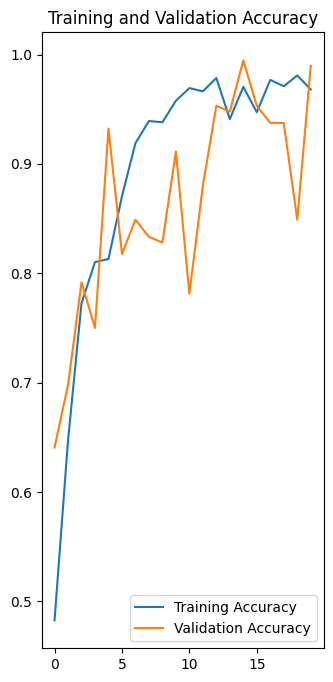

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
# Now will make a prediction